# <center>Analyzing NYC Traffic Collision Data</center>
## <center>A 15-688 Project by:</center><center><br/> Ahmet Emre Unal (ahmetemu)<br/><br/>Marco Peyrot (mpeyrotc)</center>

New York City is a beautiful city with terrible traffic. The drivers are impatient and aggressive, which results in many traffic collisions every day, some of which, quite unfortunately, lead to injuries and death.

For our project, we wanted to understand NYC's most collision-prone areas and try to predict collisions based on many factors, such as location, vehicle type, whether it's a weekday, etc.

The [NYPD Motor Vehicle Collisions](https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95/data) dataset we found was surprisingly feature-rich and populous. It also meant that there were lots of collision instances with missing data.

In [254]:
from bs4 import BeautifulSoup
import collections
import numpy as np
import pandas as pd
import re
import requests 
import scipy
from scipy.cluster.vq import kmeans, kmeans2, vq
from scipy.spatial.distance import cdist
from IPython.core.display import display, HTML
from colour import Color

# Plotting
import matplotlib
matplotlib.use('svg')
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

raw_data_file_name = 'NYPD_Motor_Vehicle_Collisions.csv'
bicycle_lanes_page_url = 'http://www.nyc.gov/html/dot/html/bicyclists/lane-list.shtml'

We started by cleaning up rows with empty and '`UNKNOWN`' values, throwing away about a third of the original dataset. We then dropped columns that either were unnecessary (like the reason for the crash, since this sort of information is not possible to infer before the collision, like the driver being distracted) or were too detailed (like the vehicle subtypes).

In [2]:
def load_data(file_name):
    collision = pd.read_csv(file_name, 
                            na_filter=False, 
                            parse_dates={'DATE_COMBINED' : ['DATE', 'TIME']}, 
                            infer_datetime_format=True)
    
    # Remove rows that don't have the necessary data
    columns_to_check_for_empty = ['LOCATION', 'LATITUDE', 'LONGITUDE', 'BOROUGH',
                                  'ZIP CODE', 'ON STREET NAME', 'CROSS STREET NAME', 
                                  'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 1']
    for column in columns_to_check_for_empty:
        collision = collision[collision[column] != '']
        collision = collision[collision[column] != 'UNKNOWN']

    # Drop unneeded columns
    columns_to_drop = ['CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 
                       'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 
                       'CONTRIBUTING FACTOR VEHICLE 5', 'LOCATION', 'OFF STREET NAME', 
                       'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 
                       'VEHICLE TYPE CODE 5']
    for column in columns_to_drop:
        collision = collision.drop(column, axis=1)
        
    # Set column types
    collision['ZIP CODE'] = collision['ZIP CODE'].astype(int)
    collision['LATITUDE'] = collision['LATITUDE'].astype(float)
    collision['LONGITUDE'] = collision['LONGITUDE'].astype(float)
    
    # Rename date column to just 'DATE'
    collision = collision.rename(columns={'DATE_COMBINED':'DATE'})
    
    # Eliminate duplicates
    collision = collision.drop_duplicates()
    
    # Reset index
    collision = collision.reset_index(drop=True)
    
    return collision

We proceeded to create two temporal features:

 1. Whether it occurred on a weekday or weekend
 2. In what 'time period' in the day it occurred

The 'time period' requires some explanation: We all know that morning and evening rush hours can be especially more collision-prone than daytime (around noon) and night time (after the evening rush and before the morning rush). We decided to create these four bins with the following time ranges:

 1. Night Time: 00:00-06:59 & 20:00-00:00
 2. Morning Rush: 07:00-10:59
 3. Night Time: 00:00-06:59 & 20:00-00:00
 4. Evening Rush: 16:00-19:59

Together with the weekday/weekend feature, this allowed us to represent the date in a way that is meaningful to a machine learning algorithm. We also assumed that, as long as it's a weekday, the exact day (whether it's a Monday or a Thursday) is not significant.

In [3]:
def create_temporal_features(collision):
    collision = _create_time_features(collision)
    collision = _create_date_features(collision)
    
    # We're done with date, we can drop it
    collision = collision.drop('DATE', axis=1)
    
    return collision
    

def _create_time_features(collision):
    # Create one-hot time of day representation
    ## Date part is unimportant
    morning_rush_begin = pd.datetime(2000, 01, 01, 07, 00, 00).time()
    morning_rush_end = pd.datetime(2000, 01, 01, 11, 00, 00).time()
    evening_rush_begin = pd.datetime(2000, 01, 01, 16, 00, 00).time()
    evening_rush_end = pd.datetime(2000, 01, 01, 20, 00, 00).time()
    collision_time = collision['DATE'].dt.time
    
    ## Night Time 00:00-06:59 & 20:00-00:00
    night_time = (collision_time >= evening_rush_end) | (collision_time < morning_rush_begin)
    night_time_onehot = pd.get_dummies(night_time).loc[:, True].astype(int)
    collision = collision.assign(NIGHT_TIME = night_time_onehot.values)
    
    ## Morning Rush 07:00-10:59
    morning_rush = (collision_time >= morning_rush_begin) & (collision_time < morning_rush_end)
    morning_rush_onehot = pd.get_dummies(morning_rush).loc[:, True].astype(int)
    collision = collision.assign(MORNING_RUSH = morning_rush_onehot.values)
    
    ## Night time 00:00-06:59 & 20:00-00:00
    day_time = (collision_time >= morning_rush_end) & (collision_time < evening_rush_begin)
    day_time_onehot = pd.get_dummies(day_time).loc[:, True].astype(int)
    collision = collision.assign(DAY_TIME = day_time_onehot.values)
    
    ## Evening Rush 16:00-19:59
    evening_rush = (collision_time >= evening_rush_begin) & (collision_time < evening_rush_end)
    evening_rush_onehot = pd.get_dummies(evening_rush).loc[:, True].astype(int)
    collision = collision.assign(EVENING_RUSH = evening_rush_onehot.values)
    
    return collision

def _create_date_features(collision):
    # Create one-hot weekday/weekend representation
    collision_day = collision['DATE'].dt.dayofweek
    
    ## Weekday 0, 1, 2, 3, 4
    ## Weekend 5, 6
    is_weekday = (collision_day <= 4)
    is_weekday_onehot = pd.get_dummies(is_weekday).astype(int)
    
    ## Weekday
    weekday_onehot = is_weekday_onehot.loc[:, True]
    collision = collision.assign(WEEKDAY = weekday_onehot.values)

    ## Weekend
    weekend_onehot = is_weekday_onehot.loc[:, False]
    collision = collision.assign(WEEKEND = weekend_onehot.values)
    
    return collision

We further proceeded to create a one-hot encoding of the vehicle types that were available in the dataset. NYPD has put almost half of the vehicles in a general group called '`PASSENGER VEHICLE`', which seems to represent the common sedan type of vehicle. Other types, like SUVs, motorcycles, small and large commercial vehicles, have their own types. 

We removed some collision types (like the collisions in which the vehicle was an '`AMBULANCE`') with very few collisions. This further cut about 5% of the dataset.

In [4]:
def create_vehicle_features(collision):
    # Create one-hot vehicle type representation
    vehicle_types_onehot = pd.get_dummies(collision.loc[:, 'VEHICLE TYPE CODE 1']).astype(int)
    
    # Merge Motorcycle & Scooter columns
    motorcycle = vehicle_types_onehot.loc[:, 'MOTORCYCLE'] + vehicle_types_onehot.loc[:, 'SCOOTER']
    vehicle_types_onehot = vehicle_types_onehot.drop('MOTORCYCLE', axis=1)
    vehicle_types_onehot = vehicle_types_onehot.drop('SCOOTER', axis=1)
    vehicle_types_onehot = vehicle_types_onehot.assign(MOTORCYCLE = motorcycle.values)
    
    # Concatanate one-hot with collisions
    collision = pd.concat([collision, vehicle_types_onehot], axis=1)
    
    # Drop unneeded collisions
    vehicles_to_drop = ['OTHER', 'AMBULANCE', 'PEDICAB', 'FIRE TRUCK', 'LIVERY VEHICLE']
    collisions_to_drop = vehicle_types_onehot.loc[:, vehicles_to_drop[0]]
    for i in xrange(1, len(vehicles_to_drop)):  # Start from 1 since we already have OTHER
        collisions_to_drop += vehicle_types_onehot.loc[:, vehicles_to_drop[i]]
    collisions_to_keep = (collisions_to_drop == 0)
    collision = collision[collisions_to_keep]
    collision = collision.reset_index(drop=True)  # Reset index due to dropped rows
    
    # Drop unneeded vehicle columns
    for column in vehicles_to_drop:
        collision = collision.drop(column, axis=1)
    
    # Drop vehicle type column
    collision = collision.drop('VEHICLE TYPE CODE 1', axis=1)
        
    return collision

We proceeded by assigning a 'severity score' to each collision. Each collision, by default, has a severity score of 1. The score increases by 2 for each injury and by 10 for each death. These are arbitrary values we came up with and have no bearing on the cost of life in these collisions.

In [5]:
# Default score values
INJURY_SCORE = 2
DEATH_SCORE = 10

def create_severity_score_feature(collision):
    # Give all collisions a score of 1 by default
    collision['SEVERITY SCORE'] = 1
    
    # For each injury, add to the score of the collision
    collision['SEVERITY SCORE'] += (collision.loc[:, 'NUMBER OF PERSONS INJURED'] * INJURY_SCORE)
    
    # For each death, add to the score of the collision
    collision['SEVERITY SCORE'] += (collision.loc[:, 'NUMBER OF PERSONS KILLED'] * DEATH_SCORE)
    
    return collision

We then load the data:

In [6]:
# Load the collision data
collision = load_data(raw_data_file_name)
collision = create_temporal_features(collision)
collision = create_vehicle_features(collision)
collision = create_severity_score_feature(collision)

print collision.head()
print collision.dtypes
print len(collision)

     BOROUGH  ZIP CODE   LATITUDE  LONGITUDE     ON STREET NAME  \
0  MANHATTAN     10075  40.775640 -73.960511     EAST 79 STREET   
1     QUEENS     11420  40.681260 -73.818679         122 STREET   
2   BROOKLYN     11217  40.684052 -73.977458    ATLANTIC AVENUE   
3      BRONX     10472  40.832281 -73.871304       CROES AVENUE   
4     QUEENS     11357  40.786854 -73.822349  PARSONS BOULEVARD   

  CROSS STREET NAME  NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  \
0       PARK AVENUE                          0                         0   
1        111 AVENUE                          0                         0   
2   FLATBUSH AVENUE                          0                         0   
3   EAST 172 STREET                          1                         0   
4         14 AVENUE                          2                         0   

   NUMBER OF PEDESTRIANS INJURED  NUMBER OF PEDESTRIANS KILLED  \
0                              0                             0   
1       

We proceed with parsing NYC's [bike lanes list web page](http://www.nyc.gov/html/dot/html/bicyclists/lane-list.shtml) to add another feature to our collision data: whether the street the collision occurred in had a bicycle lane or not. We do that by manually parsing the bicycle lanes page and matching them to the street names of collisions.

In [7]:
def get_bicycle_lanes_from_page(page_html):
    """
    Parse the table contained in the bicycle lanes webpage.

    Args:
        page_html (string): String of HTML corresponding to the data source webpage.

    Returns:
        a dictionary that contains mappings from a category to the list containing the data.
        These categories are: street, begins, ends, and borough.
    """
    soup = BeautifulSoup(page_html, 'html.parser')
    bicycle_lanes_list = {
        'street': [],
        'begins': [],
        'ends': [],
        'borough': []
    }

    table = soup.findChildren('tbody')[0]
    rows = table.findChildren(['tr'])
    
    for row in rows:
        cells = row.findChildren('td')
        content = cells[0].text
        m = re.search(r'^([a-zA-Z\s0-9\-\.,\(\)]+) (from)*(between)* '
                      r'([a-zA-Z\s0-9\-\.,\(\)]+) (to)*(and)* '
                      r'([a-zA-Z\s0-9\-\.,\(\)]+)$', content)
        
        # Content that does not follow this syntax is discarded because
        # it refers to landscapes or parks.
        if m is not None:
            bicycle_lanes_list['street'].append(m.group(1).upper())
            bicycle_lanes_list['begins'].append(m.group(4).upper())
            bicycle_lanes_list['ends'].append(m.group(7).upper())
            bicycle_lanes_list['borough'].append(cells[2].text.upper())

    return bicycle_lanes_list
    
def extract_bicycle_lanes(url):
    """
    Retrieve all of the bicycle lane information for the city of New York.

    Parameters:
        url (string): page URL corresponding to the listing of bicycle lane information.

    Returns:
        bicycle_lanes (Pandas DataFrame): list of dictionaries containing extracted lane information.
    """
    bicycle_lanes_page = requests.get(url).text
    bicycle_lanes_list = get_bicycle_lanes_from_page(bicycle_lanes_page)
            
    bicycle_lanes = pd.DataFrame(bicycle_lanes_list)
    bicycle_lanes.loc[bicycle_lanes.borough == 'THE BRONX', 'borough'] = 'BRONX'
    bicycle_lanes = bicycle_lanes.rename(columns={'borough': 'BOROUGH', 'begins': 'BEGINS', 'ends': 'ENDS', 'street': 'ON STREET NAME'})
    
    return bicycle_lanes

In [8]:
bicycle_lanes = extract_bicycle_lanes(bicycle_lanes_page_url)

print bicycle_lanes.head()
print len(bicycle_lanes)

               BEGINS BOROUGH              ENDS      ON STREET NAME
0        BOUCK AVENUE   BRONX  KINGSLAND AVENUE     ALLERTON AVENUE
1    BRONXWOOD AVENUE   BRONX     STEDMAN PLACE     ALLERTON AVENUE
2   BAYCHESTER AVENUE   BRONX     MALL ENTRANCE       BARTOW AVENUE
3       BRYANT AVENUE   BRONX    EDGEWATER ROAD  BRUCKNER BOULEVARD
4  BRUCKNER BOULEVARD   BRONX      WENNER PLACE        BRUSH AVENUE
493


The bicycle lanes are defined by four features:

 1. Which street they're on (`ON STREET NAME`)
 2. Which cross street they begin on (`BEGINS`)
 3. Which cross street they end on (`ENDS`)
 4. The borough they're on (`BOROUGH`)
 
By using these four values, we'll match them to the location of the collisions and add a 'HAS_BIKE_LANE' column to the collisions data frame, indicating whether the crash occurred on a street that has a bike lane.

In [9]:
def merge_bicycle_lanes(df1, df2, columns):
    # Populate collisions with bicycle lane data by matching on 'columns'
    result = pd.merge(df1, df2, how='left', on=columns)
    
    # Create a 'HAS_BIKE_LANE' column to indicate the presenc of a bike lane
    result = result.assign(HAS_BIKE_LANE = [0 if x is np.nan else 1 for x in result.loc[:, 'BEGINS']])
    
    # Drop unneeded columns
    result = result.drop('BEGINS', axis=1)
    result = result.drop('ENDS', axis=1)
    
    # Multiple bike lanes can be on the same street, disregard that fact
    result = result.drop_duplicates()
    
    # Reset index to account for duplicates
    result = result.reset_index(drop=True)
    
    return result

In [10]:
collision = merge_bicycle_lanes(collision, bicycle_lanes, ['ON STREET NAME', 'BOROUGH'])

print collision.head()
print collision.dtypes
print len(collision)

     BOROUGH  ZIP CODE   LATITUDE  LONGITUDE     ON STREET NAME  \
0  MANHATTAN     10075  40.775640 -73.960511     EAST 79 STREET   
1     QUEENS     11420  40.681260 -73.818679         122 STREET   
2   BROOKLYN     11217  40.684052 -73.977458    ATLANTIC AVENUE   
3      BRONX     10472  40.832281 -73.871304       CROES AVENUE   
4     QUEENS     11357  40.786854 -73.822349  PARSONS BOULEVARD   

  CROSS STREET NAME  NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  \
0       PARK AVENUE                          0                         0   
1        111 AVENUE                          0                         0   
2   FLATBUSH AVENUE                          0                         0   
3   EAST 172 STREET                          1                         0   
4         14 AVENUE                          2                         0   

   NUMBER OF PEDESTRIANS INJURED  NUMBER OF PEDESTRIANS KILLED      ...        \
0                              0                           

We now need to find areas in which collisions occur frequently. This will let us identify collision-prone areas in NYC. All the collisions we have right now have their latitude & longitude information, which is too granular to identify areas. We also have the borough and Zip codes of the locations, but those are not granular enough. What we need to do is to define 'clusters' from the locations of crashes, which we can use to determine areas. We can use the k-means algorithm to achieve this.

Usually, we try to optimize the number of means to give us a good balance of error & generalizability. While we can do that here as well, we can manually choose the number of means to specify how granular we'd like to be with our zoning: selecting a single mean will, naturally, cover the entire NYC metropolitan area but won't provide us with any additional information. By visually observing the results of choosing from a number of means, we can find a good balance of the number of zones that translate logically to the layout of the NYC metropolitan area.

**NOTE:**
Below is our test code for running the k-means algorithm on our dataset. For our final report, we will be identifying and obtaining the zones from our collision data using k-means, assigning zone IDs (the means) to the collisions and use this final version to perform predictions on future data (for example, given a car's features and the zone, predicting the expected number of injuries from a collision).

In [11]:
def k_means_test(X, K_max):
    """
    Finds the best number k for the k_means algorithm according to some features passed to this
    method.
    
    Some code has been taken from: 
    https://stackoverflow.com/questions/6645895/calculating-the-percentage-of-variance-measure-for-k-means
    especially the plotting parts.

    Parameters:
        X (DataFrame): pandas dataframe containing the features that will be used to divide the
        data into clusters.
        K-max (Integer): the maximum number of K clusters to test on.

    Returns:
        Nothing, it just plots the elbow graph that has a marker on the best number of
        clusters to use.
    """
    K = range(1, K_max)
    KM = [kmeans(X,k) for k in K]
    centroids = [cent for (cent,var) in KM]

    D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/X.shape[0] for d in dist]
    
    # Choose k
    kIdx = min([(v,i) for i,v in enumerate([((x*100) + y)/2.0 for x,y in zip(avgWithinSS, K)])])[1]

    # Plot elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
            markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for K-Means clustering')

    plt.plot()

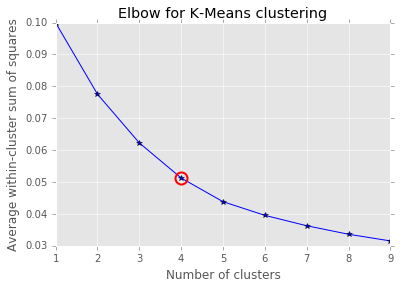

In [12]:
collision1 = collision.drop(['BOROUGH', 'ON STREET NAME', 'CROSS STREET NAME', 'UNIQUE KEY'], axis=1)

# Calculate different centroids according to different number of k's.
k_means_test(collision1.loc[:,['LATITUDE', 'LONGITUDE']], 10)

In [206]:
X = collision1.loc[:,['LATITUDE', 'LONGITUDE']]
centroids, labels = kmeans2(X,4)

In [245]:
def createPage(title, script):
    """
    Creates a webpage that will hold the map where the points of each cluster are plotted. This page
    shows an instance of Leaflet (http://leafletjs.com/).

    Parameters:
        title (string): the name of the webpage that will appear on the browser
        script (string): the location of the file that contains the plotting information (must be a
                        javascript file)

    Returns:
        The HTML code that forms the webpage.
    """
    
    page = """
        <!DOCTYPE html>
        <html>
            <head>
                <title>TITLE</title>
                <meta charset="utf-8" />
                <meta name="viewport" content="width=device-width, initial-scale=1.0">

                <link rel="stylesheet" href="https://unpkg.com/leaflet@1.0.2/dist/leaflet.css" />
                <script src="https://unpkg.com/leaflet@1.0.2/dist/leaflet.js"></script>
            </head>
            <body>
                <div id="mapid" style="width: 800px; height: 600px;"></div>
                <script src="SCRIPT"></script>
            </body>
        </html>
        """
    
    page = page.replace("TITLE", title)
    page = page.replace("SCRIPT", script)
    
    return page

def createScript(name, lat, lon, zoom):
    """
    Creates a javascript file with the basic content to display a map in a webpage.

    Parameters:
        name (string): the name (or directory) of the javascript file to be created
        lat (float): the latitude where the map will be centered
        lon (float): the longitude where the map will be centered
        zoom (int): the zoom level in which the map starts (can be changed in browser)

    Returns:
        Nothing, the file is written onto disk
    """
    
    script = """
    var mymap = L.map('mapid').setView([LAT, LON], ZOOM);
    
    L.tileLayer('https://api.tiles.mapbox.com/v4/{id}/{z}/{x}/{y}.png?access_token=pk.eyJ1IjoibWFwYm94IiwiYSI6ImNpandmbXliNDBjZWd2M2x6bDk3c2ZtOTkifQ._QA7i5Mpkd_m30IGElHziw', {
        maxZoom: 18,
        attribution: 'Map data &copy; <a href="http://openstreetmap.org">OpenStreetMap</a> contributors, ' +
            '<a href="http://creativecommons.org/licenses/by-sa/2.0/">CC-BY-SA</a>, ' +
            'Imagery © <a href="http://mapbox.com">Mapbox</a>',
        id: 'mapbox.streets'
    }).addTo(mymap);
    
    """
    script = script.replace("LAT", str(lat))
    script = script.replace("LON", str(lon))
    script = script.replace("ZOOM", str(zoom))
    
    with open(name + '.js', "w") as script_file:
        script_file.write(script)
        
def appendScript(name, lats, lngs, color, size):
    """
    Appends to a javascript file all the points to be plotted with a given color and size

    Parameters:
        name (string): the name (or directory) of the javascript file to be used
        lats (list[float]): the list of latitudes to be plotted
        lngs (list[float]): the list of longitudes to be plotted
        color (Color): the color in which the points will be plotted
        size (int): the size of each point

    Returns:
        Nothing, the file is written onto disk
    """
    
    point = """
    L.circle([LAT, LON], SIZE, {
        color: 'COLOR',
        fillColor: 'COLOR',
        fillOpacity: 0.5
    }).addTo(mymap);
    """
    
    point = point.replace('SIZE', str(size))
    point = point.replace('COLOR', str(color.hex))
        
    with open(name + '.js', "a") as script_file:
        for lat, lon in zip(lats, lngs):
            new_point = point.replace('LAT', str(lat))
            new_point = new_point.replace('LON', str(lon)) 
            script_file.write(new_point)

In [252]:
def plotPoints(X, labels, K, script, html_file, num_points, lat=40.723671, lon=-74.009725, zoom=11):
    """
    Creates a html file and a javascript file that will hold a map of a region centered at the specified latitude
    and logitude coordinates. It will plot several points based on the labels passed on to it and the number
    of clusters they map to.
    
    Parameters:
        X (pandas df): a dataframe that contains latitude and longitude values
        labels (list): holds the label for which each row in X is assigned to a cluster
        script (string): the name (or directory) of the javascript file to be used
        html_file (string): the name (or directory) of the html file to be used
        num_points (int): the maximum number of points to be plotted per cluster
        lat (float): the latitude where the map will be centered
        lon (float): the longitude where the map will be centered
        zoom (int): the zoom level in which the map starts (can be changed in browser)
        
    Returns:
        Nothing, the files are written onto disk
    """
    purple = Color("purple")
    colors = list(purple.range_to(Color("green"),K))
    
    # Append labels to coordinates
    X['label'] = labels
    
    with open(html_file + '.html', "w") as map_file:
        map_file.write(createPage(html_file, script + '.js'))
        
    createScript(script, lat, lon, zoom)
    
    for label in set(labels):
        assignments = X.loc[X.label == label, :]
        assignments = assignments.iloc[np.random.permutation(range(0,assignments.shape[0])), :].iloc[range(0,num_points), :]
        appendScript(script, assignments.loc[:,'LATITUDE'], assignments.loc[:,'LONGITUDE'], colors[label], 40)

In [253]:
plotPoints(X, labels, 4, 'file', 'page', 4000)